
# IDE activity: Time series momentum, Part 2

In this activity, you will demonstrate the advantages of utilising time series momentum strategies. In its simplest form, a time series momentum strategy uses an asset's past returns as an indicator for the current price trend. That is, the stronger the price trend, the larger the position the strategy enters to follow it. Momentum strategies are popular diversifiers in portfolio construction, given their low (and sometimes negative) correlations with equities.

The activity starts by first loading the data and calculating the returns. Following this, you will be introduced to a basic long-only strategy as a benchmark, working with the S&P 500 time series data set. You will then measure the success of the strategy using standard performance metrics, including the Sharpe, Sortino, and Calmar ratios, to assess performance of this long-only strategy. 

Next, you will explore the utility of volatility scaling to improve risk-adjusted returns (see [Harvey et al., 2018](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3175538) for more information). After volatility scaling, you will implement a basic time series momentum strategy first introduced in [Moskowitz et al., 2012](https://research.cbs.dk/en/publications/time-series-momentum) and explore its performance across different trading horizons, before moving to a more sophisticated time series momentum strategy that uses moving average convergence divergence (MACD) indicators, as reviewed in [Baz et al., 2015](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2695101). 

Finally, you will analyse the benefits of using time series momentum strategies as diversifiers when combining them in a portfolio with long-only strategies.

Over recent years, the performance of such classical time series momentum strategies has been declining, which has led to the development of more advanced deep learning trading strategies that have been shown to greatly improve these existing methodologies (see [Lim et al., 2019](https://arxiv.org/abs/1904.04912) for more information).

## 1. Import packages

Before continuing, it is important to import the various packages that will be used to analyse and visualise the data. This is achieved using the following lines of code.

In [1]:
# Importing packages to deal with data
import pandas as pd      
import numpy as np   
import datetime as dt
import yfinance as yf
# Importing packages to plot
import matplotlib.pyplot as plt

## 2. Loading the data and calculating returns

To load the required data, you can use the [Yahoo Finance API](https://pypi.org/project/yfinance/) to download S&P 500 time series data and print the data to ensure that it has loaded correctly.

In [2]:
# Loading data for S&P 500 time series
data_source = yf.Ticker('^GSPC')

# Alternatively can load FTSE100
# data_source = yf.Ticker('^FTSE')

data_hist = data_source.history(period='max')
# Print data history
data_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0,0,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0,0,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0,0,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0,0,0
1928-01-09,17.500000,17.500000,17.500000,17.500000,0,0,0
...,...,...,...,...,...,...,...
2021-11-11,4659.390137,4664.549805,4648.310059,4649.270020,2623140000,0,0
2021-11-12,4655.240234,4688.470215,4650.770020,4682.850098,2865790000,0,0
2021-11-15,4689.299805,4697.419922,4672.859863,4682.799805,2618980000,0,0


You can then filter the data to include a specified time frame. In this case, you will be filtering data between 1990 and 2009, while checking for null or zero entries.

In [3]:
# Filter data from 1990
data = data_hist["1990-01-01":"2009-12-31"].copy()

# Check for null and zero entries 
len(
  data[
    data.Close.isna() |
    data.Close.isnull() |
    data.Close < 1e-8
  ]
)

0

Before continuing, you can do a quick sanity check of the data by plotting the prices using the [matplotlib](https://matplotlib.org/) package. 

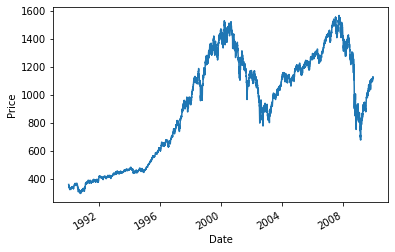

In [4]:
# Plotting prices
data.Close.plot()
plt.ylabel("Price");

With the price data correctly loaded, you will add a buffer of one year to the beginning of the time series to allow for sufficient history when using rolling estimates later.

In [5]:
data = data_hist["1988-12-01":"2009-12-31"].copy()

After correctly loading the time series data and adding the one-year buffer, you will calculate the returns from time $t-\tau$ to $t$, using the following formula: 
\begin{equation}
r_{t-\tau,t} = \dfrac{p_t-p_{t-\tau}}{p_{t-\tau}}, 
\end{equation}
where $p_t$ is price at time $t$ and $\tau$ is the offset, the number of days to calculate the returns over.

**Exercise: Complete the following function**

In [6]:
def calc_returns(srs, offset=1):
    """ 
        Parameters:
              srs: pandas time-series
              offset: number of days to offset returns
        Return:
          Calculates the returns over the past number of days 
          specified by offset
    """
    
    ### Enter code here:
    returns = srs / srs.shift(offset) - 1.0
    ###
    
    return returns

Next, print the return of the previous day as well as the following day's return, which you will use to evaluate the strategy.

In [7]:
data["daily_returns"] = calc_returns(data["Close"])
data["next_day_returns"] = data["daily_returns"].shift(-1)
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,daily_returns,next_day_returns
Date,,,,,,,,,
1988-12-01,273.679993,273.700012,272.269989,272.489990,129380000,0,0,NaN,-0.002495
1988-12-02,272.489990,272.489990,270.470001,271.809998,124610000,0,0,-0.002495,0.011479
1988-12-05,274.929993,275.619995,271.809998,274.929993,144660000,0,0,0.011479,0.009675
1988-12-06,274.929993,277.890015,274.619995,277.589996,158340000,0,0,0.009675,0.001945
1988-12-07,277.589996,279.010010,277.339996,278.130005,148360000,0,0,0.001945,-0.005537


It is sometimes advisable to [winsorise](https://en.wikipedia.org/wiki/Winsorizing) the data by capping or flooring it to be within 5 times its exponentially weighted moving (EWM) standard deviations from its EWM average. In this way, you can mitigate the effects of outliers when calculating the trend. You can winsorise the data and then plot the daily returns using the following lines of code.

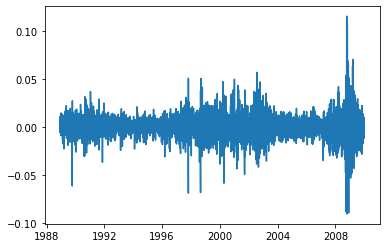

In [8]:
# Limit data to within 5 standard deviations
# Winsorise the data by capping it to be within 5 x standard deviations
VOL_THRESHOLD = 5  
data["srs"] = data["Close"]

# Smooth annual lookback window (Approx. 252 trading days/year)
SMOOTH_WINDOW = 252 


ewm = data["srs"].ewm(halflife=SMOOTH_WINDOW)
# Calculate the exponentially weighted moving mean
means = ewm.mean()
# Calculate the exponentially weighted moving standard deviation
stds = ewm.std()

# Calculating upper bound
ub = means + VOL_THRESHOLD * stds
data["srs"] = np.minimum(data["srs"], ub);

# Calculating lower bound
lb = means - VOL_THRESHOLD * stds
data["srs"] = np.maximum(data["srs"], lb);

# Next day return without capping but returns for signal with capping
data["daily_returns"] = calc_returns(data["srs"],1)

plt.plot(data["daily_returns"]);

## 3. Long-only strategy

You will first consider a very simple long-only strategy as a benchmark.
For the long-only strategy, you take a maximum long position for all times $t$ in time horizon $T$. In terms of a normalised trading signal $X_t\in[-1,1]$, where $X_t = -1$ indicates a maximum short position whereas $X_t = 1$ indicates a maximum long position, this amounts to choosing 
\begin{equation}
X_t = 1, \forall t \in T.
\end{equation}

The cumulative return of this strategy is simply
\begin{equation}
\prod_{t=0}^{T-1}(1+r_{t+1,t}) - 1
\end{equation}

You now plot the performance. To easily compare different strategies later, you can add an option to scale returns to a fixed volatility. 

In [9]:
# Rescale volatility for comparison
def rescale_to_target_volatility(srs,vol=0.15):
    return srs *  vol / srs.std() / np.sqrt(252)

def plot_captured_returns(next_day_captured, plot_with_equal_vol = None):
    """ Parameters:
            next_day_captured: time-series of next day returns
        Return:
            matplotlib.pyplot of cumulative returns """
    
    if plot_with_equal_vol is not None:
        srs = rescale_to_target_volatility(next_day_captured.copy(),vol=plot_with_equal_vol)
    else:
        srs = next_day_captured.copy()
        
    ((srs.shift(1) + 1).cumprod() - 1).plot()
    plt.ylabel("Cumulative  returns");

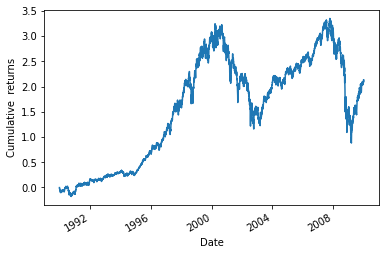

In [10]:
# Load long-only returns and plot
captured_returns_longonly = data['next_day_returns']["1990-01-01":]
plot_captured_returns(captured_returns_longonly)

So far, the results look good. While plots give a good indication as to how a strategy performs, it would be more useful to measure the performance of this strategy using some performance metrics.

### 3.1 Performance metrics

In this section, you will define metrics commonly used to measure the success of trading strategies. Many of the performance metrics are intuitive and, for those that are not, links are provided that expand on them. 

Metrics (annualised by default, $\tau = 252$):
* $\textrm{Returns}$ $:= \mathbb{E}[R_t]\cdot \tau$
* [$\textrm{Volatility}$]( https://en.wikipedia.org/wiki/Volatility_%28finance%29 ): $= \sqrt{\mathrm{Var}[R_t] \cdot \tau}$
* [$\textrm{Downside deviation}$]( https://en.wikipedia.org/wiki/Downside_risk ) $:= \sqrt{\mathrm{Var}[Loss]\cdot \tau}$
* [$\textrm{Maximum drawdown (MDD)}$]( https://en.wikipedia.org/wiki/Drawdown_%28economics%29 )$: = \max_t\{\max\{R_0,R_1,\ldots,R_t\}-R_t$\}
* $\textrm{PnL ratio}$ $:= \dfrac{\mathbb{E}[\mathrm{Profit}]}{\mathbb{E}[\mathrm{Loss}]}$

Below you will define some of these metrics.

In [11]:
def calc_downside_deviation(srs):
    """ Parameters:
            srs: pandas time-series
        Return:
            Downside Deviation (defined above) """
    negative_returns = srs.apply(lambda x: x if x < 0 else np.nan).dropna() * np.sqrt(252)
    return negative_returns.std()

def calc_max_drawdown(srs):
    """ Parameters:
            srs: pandas time-series
        Return:
            MDD (defined above) """
    cumulative_max = srs.cummax()
    drawdown = cumulative_max - srs
    return drawdown.max()

def calc_profit_and_loss_ratio(srs):
    """ Parameters:
            srs: pandas time-series
        Return:
            PnL ratio (defined above) """
    return np.mean(srs[srs>0])/np.mean(np.abs(srs[srs<0]))

The risk-adjusted performance metrics (annualised by default, $\tau = 252$):
* [$\textrm{Sharpe ratio}$](https://www.investopedia.com/terms/s/sharperatio.asp)$:=\dfrac{\mathbb{E}[R_t]}{\sqrt{\mathrm{Var}[R_t]}}\cdot\sqrt{\tau}$
* [$\textrm{Sortino ratio}$](https://www.investopedia.com/terms/s/sortinoratio.asp)$:=\dfrac{\mathbb{E}[R_t]}{\sqrt{\mathrm{Var}[Loss]}}\cdot\sqrt{\tau}$
* [$\textrm{Calmar ratio}$](https://www.investopedia.com/terms/c/calmarratio.asp)$:=\dfrac{\mathbb{E}[R_t]}{\textrm{MDD}}\cdot\tau$

**Exercise: Complete the following function definition by defining the risk-adjusted performance metrics** 

That is, define the Sharpe, Sortino, and Calmar ratios.


In [12]:
def calculate_statistics(next_day_captured, print_results=True):
    """ Parameters:
            srs: pandas time-series
            print_results: bool to print statistics
        Return:
            Metrics and risk adjusted performance metrics (defined above) """
    
    
    srs = next_day_captured.shift(1)
    mean = srs.mean()
    vol = srs.std()
    
    # Calculate annualised metrics:
    returns_annualised =  mean*252
    vol_annualised = vol*np.sqrt(252)
    downside_devs_annualised = calc_downside_deviation(srs)
    max_drawdown = calc_max_drawdown(srs)
    pnl_ratio = calc_profit_and_loss_ratio(srs)
    perc_positive_return = len(srs[srs>0])/len(srs)
    
    """
        Exercise: complete the following ratio definitions
    """
    # Calculate risk-adjusted performance metrics:
    
    ### Enter code here:
    sharpe = mean/vol*np.sqrt(252)   
    sortino = mean / downside_devs_annualised * 252
    calmar = mean / max_drawdown * 252
    ###
    
    # Print results
    if print_results:
        print("\033[4mPerformance Metrics:\033[0m")
        print(f"Annualised Returns = {returns_annualised:.2%}")
        print(f"Annualised Volatility = {vol_annualised:.2%}")
        print(f"Downside Deviation = {downside_devs_annualised:.2%}")
        print(f"Maximum Drawdown = {max_drawdown:.2%}")
        print(f"Sharpe Ratio = {sharpe:.2f}")
        print(f"Sortino Ratio = {sortino:.2f}")
        print(f"Calmar Ratio = {calmar:.2f}")
        print(f"Percentage of positive returns = {perc_positive_return:.2%}")
        print(f"Profit/Loss ratio = {pnl_ratio:.3f}")
   
    # Return performance metrics
    return {
        "returns_annualised":  returns_annualised,
        "vol_annualised": vol_annualised,
        "downside_deviation_annualised": downside_devs_annualised,
        "max_drawdown": max_drawdown,
        "sharpe": sharpe,
        "sortino": sortino,
        "calmar": calmar,
        "pnl_ratio": pnl_ratio,
      }

# Calculate performance metrics for basic long-only strategy defined above
stats_longonly = calculate_statistics(captured_returns_longonly)

Performance Metrics:
Annualised Returns = 7.39%
Annualised Volatility = 18.60%
Downside Deviation = 14.10%
Maximum Drawdown = 20.62%
Sharpe Ratio = 0.40
Sortino Ratio = 0.52
Calmar Ratio = 0.36
Percentage of positive returns = 52.89%
Profit/Loss ratio = 0.958


## 4. Volatility scaling

Before moving on to time series momentum strategies, you will be briefly introduced to volatility scaling.

Volatility scaling has been proven to play a crucial role in enhancing the performance of time series momentum strategies. By scaling the returns of an asset by its volatility, you can set it so that each asset targets a consistent amount of risk.
Here, the target risk, represented by $\sigma_{tgt}$, will be set to 15%.


**Exercise: Complete the function that calculates scaled returns**
\begin{equation}
r^\textrm{scaled}_{t-1,t}=\dfrac{\sigma_\mathrm{tgt}}{\sigma_{t}}r_{t+1,t}
\end{equation}
Here $\sigma_{t}$ is an ex-ante estimate of the volatility at time $t$. This can be computed using an exponentially weighted moving (EWM) standard deviation of a given span which you will set to be 60 days (see [pandas.DataFrame.ewm](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html) for more information).

In [13]:
VOL_LOOKBACK = 60 # Lookback window for calculating daily volatility
VOL_TARGET = 0.15 # Setting annualised volatility target

def volatility_scaled_returns(daily_returns, vol_lookback = VOL_LOOKBACK, vol_target = VOL_TARGET):
    """ Parameters:
            daily_returns: pandas time-series of the daily returns
            print_results: bool to print statistics
        Return:
            Volatility scaled returns for annualised VOL_TARGET of 15% """
    
    #  Complete function
    
    ### Enter code here:
    daily_volatility = daily_returns.ewm(span=vol_lookback, min_periods=vol_lookback).std().fillna(method="bfill")
    annualised_volatility = daily_volatility * np.sqrt(252) # annualised
    scaled_returns = vol_target * daily_returns / annualised_volatility.shift(1) # shift because ex-ante
    ###
    
    return scaled_returns

In [14]:
# Calculate volatility scaled returns
data['scaled_returns'] = volatility_scaled_returns(data["daily_returns"])
print(f"Signal annualised volatility: {data['scaled_returns'].std()*np.sqrt(252):.2%}")

Signal annualised volatility: 15.49%


In [15]:
data["trading_rule_signal"] = (1 + data["scaled_returns"]).cumprod()
data["scaled_next_day_returns"] = data["scaled_returns"].shift(-1)

To emphasise the benefits of volatility scaling, plot the returns and the volatility-scaled returns.

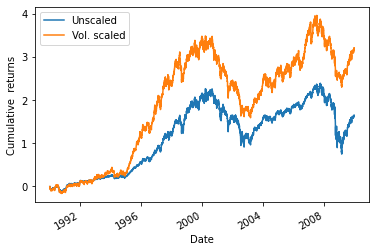

In [16]:
captured_returns_volscaled_lo = data["scaled_next_day_returns"]["1990-01-01":]
# Plot unscaled returns
plot_captured_returns(captured_returns_longonly, plot_with_equal_vol = VOL_TARGET)
# Plot volatility-scaled returns
plot_captured_returns(captured_returns_volscaled_lo, plot_with_equal_vol = VOL_TARGET)
plt.legend(["Unscaled", "Vol. scaled"]);

While you can see that higher cumulative returns are obtained using volatility scaling, you can assess the difference quantitatively by printing the performance metrics for both strategies.

In [17]:
print("Vol. scaled long only:")
stats_volscaled_longonly = calculate_statistics(captured_returns_volscaled_lo)

Vol. scaled long only:
Performance Metrics:
Annualised Returns = 8.49%
Annualised Volatility = 15.43%
Downside Deviation = 10.76%
Maximum Drawdown = 11.17%
Sharpe Ratio = 0.55
Sortino Ratio = 0.79
Calmar Ratio = 0.76
Percentage of positive returns = 52.89%
Profit/Loss ratio = 0.975


Below, note how the performance of the unscaled long-only strategy is less impressive than the volatility-scaled strategy. 

In [18]:
print("Unscaled long only:")
stats_longonly = calculate_statistics(captured_returns_longonly)

Unscaled long only:
Performance Metrics:
Annualised Returns = 7.39%
Annualised Volatility = 18.60%
Downside Deviation = 14.10%
Maximum Drawdown = 20.62%
Sharpe Ratio = 0.40
Sortino Ratio = 0.52
Calmar Ratio = 0.36
Percentage of positive returns = 52.89%
Profit/Loss ratio = 0.958


## 5. Time series momentum

## For a simple portofolio with a single asset, the returns of a time series momentum (TSMOM) strategy are expressed as:  

\begin{equation}
r_{t+1,t}^\mathrm{TSMOM}=X_t \dfrac{\sigma_\mathrm{tgt}}{\sigma_t}r_{t+1,t}.
\end{equation}
Here $r_{t+1, t}^{\mathrm{TSMOM}}$ is the realised return of the strategy from day $t$ to $t+1$. 

As before, $r_{t+1,t}$ is the one-day return, $\sigma_{tgt}$ is the annualised volatility target, set to be 15%, $\sigma_t$ is the annualised ex-ante volatility, computed using an EWM standard deviation and most importantly, $X_t \in [-1, 1]$ is the trading rule or signal, where $X_t = -1$ indicates a maximum short position whereas $X_t = 1$ indicates a maximum long position.



Next, you can look at the simple time series momentum strategy introduced in [Moskowitz et al. (2012)](https://www.sciencedirect.com/science/article/pii/S0304405X11002613) and compare this with the benchmark long-only strategy introduced above.


The general idea of a basic time series momentum strategy is to take a maximum long position when the expected trend is positive and a maximum short position when the expected trend is negative. You will use annual returns to predict the trend, then take a decision on what position to take based on this predicted trend.


Formally, you define this as:
\begin{equation}
X_t = \mathrm{sgn}(r_{t-252,t}),
\end{equation}
where we have considered an annual strategy (approx. 252 trading days in a year).

In [19]:
# Note that you are using the volatility-scaled framework
data["annual_returns"] = calc_returns(data["srs"], 252)

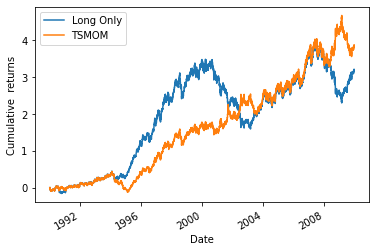

In [20]:
# With the calculated returns, adjust your trading position accordingly
captured_returns_volscaled_tsmom = (
    np.sign(data["annual_returns"])*data["scaled_next_day_returns"]
)["1990-01-01":]

# Plot the time series momentum strategy against the long-only strategy
plot_captured_returns(captured_returns_volscaled_lo, plot_with_equal_vol = VOL_TARGET)
plot_captured_returns(captured_returns_volscaled_tsmom, plot_with_equal_vol = VOL_TARGET)
plt.legend(["Long Only", "TSMOM"]);

In [21]:
# Calculate performance metrics
stats_volscaled_tsmom = calculate_statistics(captured_returns_volscaled_tsmom)

Performance Metrics:
Annualised Returns = 9.24%
Annualised Volatility = 15.42%
Downside Deviation = 10.74%
Maximum Drawdown = 11.63%
Sharpe Ratio = 0.60
Sortino Ratio = 0.86
Calmar Ratio = 0.79
Percentage of positive returns = 52.65%
Profit/Loss ratio = 0.992


**Exercise: Look at the effects of using trends based on different timescales**


So far, you have only worked with an annual timescale to estimate the trend. 
Consequently, plot the returns for a time series momentum strategy with trends estimated over the following timescales:
* 1 week
* 1 month
* 1 quarter
* Half a year

Calculate the cumulative returns for these timescales.

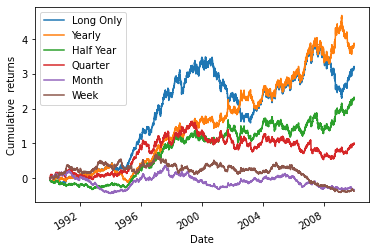

In [30]:
### Enter code here:
def tsmom_returns(interval):
    """ Parameters:
            interval: interval time to calculate tsmom
        Return:
            Tsmom cumulative returns for calculated interval """
    
    interval_srs = calc_returns(data["srs"], interval)
    captured_returns_volscaled_tsmom_interval = (
        np.sign(interval_srs)*data["scaled_next_day_returns"]
    )["1990-01-01":]
    return captured_returns_volscaled_tsmom_interval

# Plot the time series momentum strategy against the long-only strategy
plot_captured_returns(captured_returns_volscaled_lo, plot_with_equal_vol = VOL_TARGET)
plot_captured_returns(captured_returns_volscaled_tsmom, plot_with_equal_vol = VOL_TARGET)
    
signal_intervals = [126, 63, 21, 5]
for interval in signal_intervals:
    plot_captured_returns(tsmom_returns(interval))

plt.legend(["Long Only", "Yearly", "Half Year", "Quarter", "Month", "Week"]);
###

## 6. Combination of signals

Sometimes, more of a weighting is given to signals measured recently than further back in time.
You will next explore how to consider weighting signals using different timescales and how that impacts performance.

**Exercise: Weighting signals using different timescales**
 
Try combining the 1 month and 1 year signal with weighting $w$ and $(1-w)$ respectively, where $w \in \lbrace 0.0, 0.25, 0.5, 0.75, 1.0 \rbrace$
\begin{equation}
X_t^{(i)} = w \cdot\mathrm{sgn}(R_{t-21,t}) + (1-w)\cdot\mathrm{sgn}(R_{t-252,t}) \quad w \in [0,1]
\end{equation}

weight - 0
Performance Metrics:
Annualised Returns = 9.24%
Annualised Volatility = 15.42%
Downside Deviation = 10.74%
Maximum Drawdown = 11.63%
Sharpe Ratio = 0.60
Sortino Ratio = 0.86
Calmar Ratio = 0.79
Percentage of positive returns = 52.65%
Profit/Loss ratio = 0.992

weight - 0.25
Performance Metrics:
Annualised Returns = 6.70%
Annualised Volatility = 13.10%
Downside Deviation = 9.69%
Maximum Drawdown = 11.63%
Sharpe Ratio = 0.51
Sortino Ratio = 0.69
Calmar Ratio = 0.58
Percentage of positive returns = 52.65%
Profit/Loss ratio = 0.982

weight - 0.5
Performance Metrics:
Annualised Returns = 4.16%
Annualised Volatility = 12.23%
Downside Deviation = 11.01%
Maximum Drawdown = 11.63%
Sharpe Ratio = 0.34
Sortino Ratio = 0.38
Calmar Ratio = 0.36
Percentage of positive returns = 32.46%
Profit/Loss ratio = 0.990

weight - 0.75
Performance Metrics:
Annualised Returns = 1.61%
Annualised Volatility = 13.10%
Downside Deviation = 9.46%
Maximum Drawdown = 11.63%
Sharpe Ratio = 0.12
Sortino Ratio 

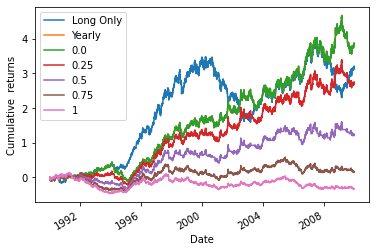

In [41]:
### Enter code here:
def combine_weighting(w):
    srs = (
        w * np.sign(calc_returns(data["trading_rule_signal"], 21)) 
        * data["scaled_next_day_returns"]
        + (1-w) * np.sign(calc_returns(data["srs"], 252))
        * data["scaled_next_day_returns"]
    )["1990-01-01":]
    
    plot_captured_returns(srs, plot_with_equal_vol = VOL_TARGET)
    print(f"weight - {w}")
    calculate_statistics(srs)
    print()

plot_captured_returns(captured_returns_volscaled_lo, plot_with_equal_vol = VOL_TARGET)
plot_captured_returns(captured_returns_volscaled_tsmom, plot_with_equal_vol = VOL_TARGET)
for weight in [0, 0.25, 0.5, 0.75, 1]:
    combine_weighting(weight)
plt.legend(["Long Only", "Yearly", "0.0", "0.25", "0.5", "0.75", "1"]);


###

## 7. Moving average convergence divergence (MACD)

## The time series momentum strategy introduced above is a simple trading rule.
Since the inception of time series momentum, more sophisticated methods have been proposed.
Next, you will consider the work introduced in [Baz et al. (2015)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2695101), which focuses on the volatility-normalised moving average convergence divergence (MACD) indicators.

The trend estimator, $Y_t$, and position sizing, $X_t$, are obtained through the following steps:
1. Compute the MACD signal as the difference between a short (S) and long (L) exponentially weighted mean average (EWMA) of the price $p_t$ (here (S, L) could be (32, 96) days):
\begin{equation}
MACD(t,S,L) = EWMA(p_t,S) - EWMA(p_t,L)
\end{equation}
2. Normalise the MACD signal with the EWM standard deviation (EWMSTD) of price of span 63 days.
\begin{equation}
 q_t = \frac{MACD(t, S, L)}{EWMSTD(p_t,63)}
\end{equation}
3. Standardise the signal with an EWM standard deviation of itself of span 252 days.
\begin{equation}
Y_t = \dfrac{q_t}{EWMSTD(q_t,252)}
\end{equation}
4. Finally, transform the signal by a squashing or response function.
\begin{equation}
X_t = \phi(Y_t), \quad \textrm{where} \quad \phi(y)=\frac{y\exp\left(\frac{-y^2}{4}\right)}{0.89}.
\end{equation}

Comments on the response function and its meaning are expanded on below.

Multiple signals with different timescales can also be averaged to give a final position:
\begin{equation}
\tilde{Y}_t=\frac{1}{3}\sum^3_{k=1}Y_t(S_k,L_k).
\end{equation}

Note that the timescale S (or L), as defined in the above paper, corresponds to `1/alpha` in terms of the smoothing factor `alpha` used in the `pandas.ewm` function. Alternatively, you could also use `span=2*S-1`

Below, the code for the MACD strategy as defined above is provided.

In [43]:
# Define position sizing function
def phi(y):
    return y * np.exp(-(y ** 2) / 4) / 0.89

# Short and long trend combinations used for MACD
MACD_TREND_COMBINATIONS = [(8, 24), (16, 48), (32, 96)]

class MACDStrategy:
    def __init__(self, trend_combinations=None):
        # Setting parameters
        self.x_vol_window = 63
        self.y_vol_window = 252

        if trend_combinations is None:
            self.trend_combinations = MACD_TREND_COMBINATIONS
        else:
            self.trend_combinations = trend_combinations

    def compute_indiv_signal(self, prices, short_window, long_window):
        # Compute individual signals

        # Compute trend over short timescale
        short_trend = prices.ewm(alpha=1.0/short_window).mean()
        # Compute trend over long timescale
        long_trend = prices.ewm(alpha=1.0/long_window).mean()

        x = short_trend - long_trend
        y = x / prices.rolling(self.x_vol_window).std().fillna(method="bfill")
        z = y / y.rolling(self.y_vol_window).std().fillna(method="bfill")
        return z

    def get_signal(self, prices):
        # Calculate combined signal
        trend_combinations = self.trend_combinations
        signal_df = None
        
        for short_window, long_window in trend_combinations:

            indiv_signal = self.compute_indiv_signal(prices, short_window, long_window)

            if signal_df is None:
                signal_df = phi(indiv_signal)
            else:
                signal_df += phi(indiv_signal)

        return signal_df / len(trend_combinations)

Next, look closer at the response function $\phi(y)$ defined above.

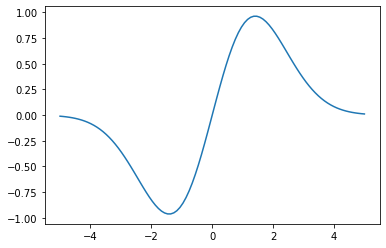

In [44]:
x = np.linspace(-5,5, 100)
plt.plot(x,phi(x));

You can see that positions are increased until $\left|Y_t\right| = \sqrt{2}$, before decreasing back to 0 for larger moves. The idea is that you are less certain of larger moves and thus downscale the signal.

Next, calculate the (volatility-scaled) returns using the combined MACD strategy for different lookback filters and compare these strategies to the long-only strategy.

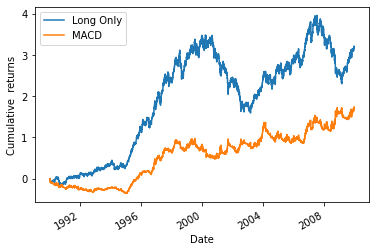

In [45]:
# Calculate returns using MACD
captured_returns_volscaled_macd = (
    MACDStrategy().get_signal(data["srs"])*data["scaled_next_day_returns"]
)["1990-01-01":]

# Plot cumulative returns of MACD vs long only
plot_captured_returns(captured_returns_volscaled_lo, plot_with_equal_vol = VOL_TARGET)
plot_captured_returns(captured_returns_volscaled_macd, plot_with_equal_vol = VOL_TARGET)
plt.legend(["Long Only", "MACD"]);

Using a combination of signals and averaging them seems to give less than satisfactory results. Consequently, you can study and plot the performances of the filters listed in MACD_TREND_COMBINATIONS instead.

**Exercise: Calculate the returns using MACD and the different filters in the list MACD_TREND_COMBINATIONS** 

Once calculated, plot the captured returns, rescaling the time series to have 15% volume to compare them. 


Long Only:
Performance Metrics:
Annualised Returns = 8.49%
Annualised Volatility = 15.43%
Downside Deviation = 10.76%
Maximum Drawdown = 11.17%
Sharpe Ratio = 0.55
Sortino Ratio = 0.79
Calmar Ratio = 0.76
Percentage of positive returns = 52.89%
Profit/Loss ratio = 0.975

TSMOM:
Performance Metrics:
Annualised Returns = 9.24%
Annualised Volatility = 15.42%
Downside Deviation = 10.74%
Maximum Drawdown = 11.63%
Sharpe Ratio = 0.60
Sortino Ratio = 0.86
Calmar Ratio = 0.79
Percentage of positive returns = 52.65%
Profit/Loss ratio = 0.992

MACD(S, L) = (8, 24):
Performance Metrics:
Annualised Returns = 2.42%
Annualised Volatility = 12.23%
Downside Deviation = 9.02%
Maximum Drawdown = 11.57%
Sharpe Ratio = 0.20
Sortino Ratio = 0.27
Calmar Ratio = 0.21
Percentage of positive returns = 51.08%
Profit/Loss ratio = 0.990

MACD(S, L) = (16, 48):
Performance Metrics:
Annualised Returns = 3.20%
Annualised Volatility = 10.80%
Downside Deviation = 8.19%
Maximum Drawdown = 8.23%
Sharpe Ratio = 0.30
Sort

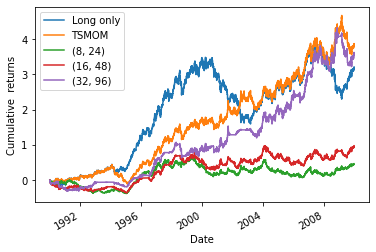

In [54]:
### Enter code here:
plot_captured_returns(captured_returns_volscaled_lo, plot_with_equal_vol = VOL_TARGET)
print("Long Only:")
calculate_statistics(captured_returns_volscaled_lo)

plot_captured_returns(captured_returns_volscaled_tsmom, plot_with_equal_vol = VOL_TARGET)
print("\nTSMOM:")
calculate_statistics(captured_returns_volscaled_tsmom)

legends = ["Long only", "TSMOM"]
for windows in MACD_TREND_COMBINATIONS:
    captured_returns_volscaled_macd = (
        MACDStrategy([windows]).get_signal(data["srs"])*data["scaled_next_day_returns"]
    )["1990-01-01":]
    legends.append(str(windows))
    plot_captured_returns(captured_returns_volscaled_macd, plot_with_equal_vol = VOL_TARGET)
    print("\nMACD(S, L) = " + str(windows) + ":")
    calculate_statistics(captured_returns_volscaled_macd)

plt.legend(legends)
###

## 8. Use cases of momentum strategies in portfolio construction

Momentum strategies, as offered by commodity trading advisors (CTAs), have been popular diversifiers in portfolios of, for example, pension funds. Even if returns are small, but the strategy has low correlation with the long-only strategy, you can build portfolios that can outperform long-only strategies in risk-adjusted terms.

**Exercise: Portfolio construction**

Above, you defined the volatility-scaled long-only and time series momentum strategies and stored the return series in the variables `captured_returns_volscaled_lo` and `captured_returns_volscaled_tsmom`, respectively. For this exercise, complete the following:

a) Compute the correlations between the two return series.

b) Build a portfolio that is equally weighted between the long-only and time series momentum strategies. This makes sense given that the strategies have similar volatility (both target 15%) and similar returns. Alternatively, you can also construct the optimal portfolio in a Markowitz sense. Plot the returns of the portfolio and compare it to the individual strategies. 

In [55]:
### Part A
### Enter code here:
captured_returns_volscaled_lo.corr(captured_returns_volscaled_tsmom)
###

0.49234078883689075

Portfolio equal weight:
Performance Metrics:
Annualised Returns = 8.87%
Annualised Volatility = 13.32%
Downside Deviation = 11.05%
Maximum Drawdown = 10.96%
Sharpe Ratio = 0.67
Sortino Ratio = 0.80
Calmar Ratio = 0.81
Percentage of positive returns = 39.90%
Profit/Loss ratio = 0.978


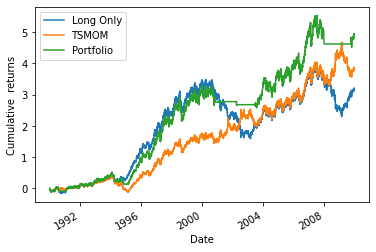

In [69]:
### Part B
### Enter code here:
print("Portfolio equal weight:")
portfolio_srs = 0.5*captured_returns_volscaled_tsmom + 0.5*captured_returns_volscaled_lo
calculate_statistics(portfolio_srs)

plot_captured_returns(captured_returns_volscaled_lo, plot_with_equal_vol = VOL_TARGET)
plot_captured_returns(captured_returns_volscaled_tsmom, plot_with_equal_vol = VOL_TARGET)
plot_captured_returns(portfolio_srs, plot_with_equal_vol = VOL_TARGET)
plt.legend(["Long Only", "TSMOM", "Portfolio"]);
###